# Проект для «Викишоп»

## Резюме исследования

**Заголовок:** Классификация комментариев пользователей на позитивные и негативные

**Описание проекта:** Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

**Критерии, которые важны заказчику:**
Значение метрики *F1* на тестовой выборке не меньше 0.75

**Цель исследования:** 
* Обучить модель классифицировать комментарии на позитивные и негативные

**Ход исследования:**
* Загрузка датасета с разметкой о токсичности правок и анализ общей информации
* Предобработка данных: выявление дубликатов, преобразование аномальных значений, корректировка типов данных
* Исследовательский анализ данных: анализ количественных и категориальных признаков, корреляционный анализ признаков
* Формирование пайплайна и обучение моделей классификации (**таргет - маркер токсичности комментария в столбце `toxic`**), оценка их качества

**Общий вывод:** резюмирование полученных результатов, формулировка ключевых выводов

## Импорт библиотек

In [1]:
!pip install shap -q
!pip install numpy==1.22.4 -q
!pip install matplotlib==3.5.3 -q
!pip install spacy==3.7.4 --no-build-isolation -q

In [2]:
# Импортируем библиотеки для работы над проектом

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
import time
import shap
import sklearn
import re
import spacy
import math
import nltk

from IPython.display import display, Markdown

from scipy.sparse import hstack

from tqdm import notebook
from nltk.corpus import stopwords

# загружаем класс pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold, KFold, cross_val_predict

# загружаем функцию для работы с метриками
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix

# загружаем функцию для копирования параметров модели без обученных весов
from sklearn.base import clone

# Загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from catboost import CatBoostClassifier

from typing import Union, List, Dict

from numpy.random import RandomState

# Задаём настройки для разделения выборки
RANDOM_STATE = 42
TEST_SIZE = 0.1

# Устанавливаем размер для всех графиков
plt.rcParams['figure.figsize'] = (12, 8);

# Настройка отображения
pd.set_option('display.max_columns', None)  # Все столбцы
pd.set_option('display.width', None)        # Ширина отображения
pd.set_option('display.max_colwidth', None)   # Максимальная ширина столбца
pd.set_option('display.float_format', '{:.2f}'.format)  # Формат чисел

/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore


## Классы и функции

### Классы для обработки датасета

In [3]:
# Создадим классы для работы с датасетами и колонками

# Класс (датафрейм)
class Data:
    def __init__(self, data: pd.DataFrame):
        if not isinstance(data, pd.DataFrame):
            raise TypeError('Данные должны быть типа pd.DataFrame')
        
        self.data = data
        self.X_train = None
        self.X_test_transformed = None
        self.y_train = None
        self.y_test = None
        
        self.selected_features = list(self.data.columns)
        
    def show_info(self): # Функция для анализа общей информации по датасету
        self.data.info()

    def print_head(self, n: int = 5): # Функция для ознакомления с данными
        if not isinstance(n, int) or n <= 0:
            raise ValueError('Параметр n должен быть положительным целым числом больше нуля')
        return self.data.head(n)

    def unify_columns(self, df: pd.DataFrame): # Функция для перевода имён столбцов по словарю
        new_cols = {}
        for eng_key, ru_names in dict_column_translations.items():
            for ru_name in ru_names:
                if ru_name in df.columns:
                    new_cols[ru_name] = eng_key
                    break
        df.rename(columns=new_cols, inplace=True)
    
    def get_numeric_columns(self) -> list: # Функция для получения списка столбцов с числовыми данными
        return self.data.select_dtypes(include=['number']).columns.tolist()
    
    def describe_numeric(self, percentiles=[0.25, 0.5, 0.75, 0.95, 0.99, 0.995, 0.997, 0.999]): # Функция для ознакомления с количественными показателями
        numeric_columns = self.get_numeric_columns()
        return self.data[numeric_columns].describe(percentiles=percentiles)
    
    def count_duplicates(self): # Функция для подсчета явных дубликатов
        return self.data.duplicated().sum()
    
    def get_duplicate_rows(self): # Функция для вывода явных дубликатов
        return self.data[self.data.duplicated(keep=False)]
    
    def get_string_columns(self): # Возвращает список строковых столбцов
        string_columns = self.data.select_dtypes(include=['object', 'string', 'category']).columns
        if string_columns.empty:
            print('Строковых и категориальных столбцов нет')
            return []
        else:
            return string_columns
    
    def show_unique_vals_str_cat_columns(self, column_name: Union[str, list[str], None] = None): # Выводит уникальные значения в строковых столбцах
        max_display = 30
        if column_name is None:
            columns = self.get_string_columns()
        elif isinstance(column_name, str):
            columns = [column_name]
        else:
            columns = column_name
            
        for col in columns:
            unique_values = sorted(self.data[col].dropna().unique())
            print(f'Уникальные значения для столбца: {col}')
            print(f'Количество уникальных значений: {len(unique_values)}')
            if len(unique_values) <= max_display:
                print(unique_values)
                print('-' * 30)
            else:
                print(unique_values[:max_display])
                print('-' * 30)
                
    def drop_duplicate_rows(self): # Функция для удаления явных дубликатов
        self.data.drop_duplicates(keep='first', inplace=True)
        return self.data

    def count_missing_values(self): # Функция для подсчета строк с пропущенными значениями
        return self.data.isna().sum()

    def fill_na_categorical(self):
        """
        Заполняет пропуски в категориальных столбцах значением 'unknown'.
        Работает и для object, и для category.
        """
        # Определяем категориальные столбцы
        cat_columns = [
            col for col in self.data.columns
            if self.data[col].dtype == object or pd.api.types.is_categorical_dtype(self.data[col])
        ]
        
        for col in cat_columns:
            col_obj = Column(self.data, col)
            
            # Если колонка Categorical, добавляем новую категорию
            if pd.api.types.is_categorical_dtype(col_obj.get_type()):
                col_obj.data[col].cat.add_categories(['unknown'], inplace=True)
            
            col_obj.fill_na('unknown')
        
        print(f'Пропуски в {len(cat_columns)} категориальных столбцах заменены на "unknown".')


    
    def drop_na(self, column_name: str): # Функция для удаления строк с пропущенными значениями
        self.data.dropna(subset=[column_name], inplace=True)
        return self.data
    
    def count_rows(self): # Функция для подсчета строк
        return len(self.data)
    
    def to_lowercase_columns(self): # Фунция для приведения имен столбцов в нижний регистр
        self.data.columns = self.data.columns.str.lower()
        print(self.data.columns)
    
    def replace_multiple_column_name(self, replacements: dict): # Функция для множественной замены символов в названиях столбцов
        def replace_chars(value):
            for old, new in replacements.items():
                value = value.replace(old, new)
            return value
        
        self.data.columns = self.data.columns.map(replace_chars)
        print(self.data.columns)
        
    def process_string_columns(self, columns, replacements=dict, lowercase_list=None):
        for col in columns:
            col_obj = Column(self.data, col)
            
            if lowercase_list and col in lowercase_list:
                col_obj.to_lowercase_rows()
                
            if replacements:
                col_obj.replace_strings(replacements)
                
            self.show_unique_vals_string_columns(column_name=col)
    
    def convert_columns_to_float(self, column_names: list[str], replacements: Union[Dict, None] = None): # Функция для замены типа данных на 'float'
        for col in column_names:
            if col in self.data.columns:
                col_obj = Column(self.data, col)
                if replacements:
                    col_obj.replace_strings(replacements)
                col_obj.change_type('float')
                print(f'Тип данных для столбца {col} изменен на {col_obj.get_type()}')
                
    def modify_data(self, index: str, columns: str, values: str, column_rename: Dict, column_order: List):
        '''Функция для трансформации датасета с выделением периодов в отдельные столбцы'''
        transformed_data = (self.data.pivot(index=index, columns=columns, values=values)\
              .reset_index()\
              .rename(columns=column_rename)\
              .rename_axis(None, axis=1)
             )\
        .copy()

        # Определяем желаемый порядок столбцов
        transformed_data = transformed_data[column_order]

        # Создаем новый экземпляр класса Data()
        new_data = Data(transformed_data)
        
        # Можно сохранить оригинальное имя с суффиксом
        new_data.name = f'{self.name}' if hasattr(self, 'name') else 'modified_dataset'

        # Возвращаем результат
        return new_data

    
    # Подготовка данных для тестирование модели, оценка качества модели
    
    def split(self, target_column: str, random_state=42, stratify=None): # Функция для разделения выборки на тренировочную и тестовую
        if target_column not in self.data.columns:
            raise ValueError(f"Целевая колонка '{target_column}' отсутствует в данных")
        
        X = self.data.drop(columns=target_column)
        y = self.data[target_column]
        
        stratify_param = y if stratify else None
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, random_state=random_state, stratify=stratify_param
        )
        
        print(f'Разделение завершено: обучающая выборка - {self.X_train.shape}, тестовая - {self.X_test.shape}')

        
    def select_features(self, features: list[str]): # Функция для отбора фичей
        # Проверяем, все ли запрошенные признаки есть в исходных данных
        missing = [f for f in features if f not in self.data.columns]
        if missing:
              raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')
        # Отбираем только нужные признаки
        self.selected_features = features
        print(f'Выбраны следующие признаки: {features}')
        
    def reset_features(self):
        self.selected_features = list(self.data.columns)
        print('Сброшен выбор признаков — используются все признаки.')
        
    def count_linear_regression_metrics(self, y_true_list: list, y_pred_list: list, model_names: list[str]) -> pd.DataFrame: # Функция для подсчета метрик линейной регресии
        if not (len(y_true_list) == len(y_pred_list) == len(model_names)):
            raise ValueError('Все входные списки должны быть одинаковой длины.')

        results = []

        for y_true, y_pred, name in zip(y_true_list, y_pred_list, model_names):
            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)

            results.append({
                'Model': name,
                'MSE': round(mse, 2),
                'RMSE': round(rmse, 2),
                'MAE': round(mae, 2),
                'R2': round(r2, 2)
            })

        return pd.DataFrame(results)

    
    def count_logistic_regression_metrics(self, y_true: np.array, y_pred: np.array): # Функция для подсчета метрик логистической регресии
    
        accuracy = accuracy_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
    
        results = {
            'accuracy': round(accuracy, 2),
            'recall': round(recall, 2),
            'precision': round(precision, 2)
        }

        return pd.DataFrame([results])


    def threshold_table(self, y_true: np.array, y_proba): # Функция для вывода таблицы метрик Precision, Recall при разных порогах
        
        thresholds = np.arange(0.0, 1.0, 0.02)  # от 0 до 1 с шагом 0.02
        rows = []
    
        total_class_1 = (y_true == 1).sum()  # сколько всего объектов класса 1
    
        for thr in thresholds:
            y_pred = (y_proba >= thr).astype(int)  # применяем порог
            recall = recall_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred, zero_division=0)
            predicted_count = y_pred.sum()
            accuracy = accuracy_score(y_true, y_pred)

            # Считаем False Positive и False Negative
            fp = ((y_pred == 1) & (y_true == 0)).sum()
            fn = ((y_pred == 0) & (y_true == 1)).sum()
    
            rows.append({
                'Порог': round(thr, 2),
                'Recall': round(recall, 3),
                'Precision': round(precision, 3),
                'Accuracy':accuracy,
                'Количество False Positive':fp,
                'Количество False Negative':fn,
                'Число предсказанных объектов': predicted_count,
                'Всего объектов класса 1': total_class_1
            })

        return pd.DataFrame(rows)

### Классы для обработки столбцов

In [4]:
# Класс (столбец датафрейма)
class Column():
    def __init__(self, data: pd.DataFrame, column_name: str):
        self.data = data
        self.column_name = column_name
        self.series = data[column_name]
        
        if column_name not in self.data.columns:
            raise KeyError(f'Столбец "{column_name}" не найден в датафрейме')
    
    def describe_numeric(self, percentiles=[0.25, 0.5, 0.75, 0.95, 0.99, 0.995, 0.997, 0.999]): # Функция для ознакомления с количественными показателями
        return self.series.describe(percentiles=percentiles)
    
    def count_values(self): # Функция для вывода и подсчета уникальных значений
        return self.series.value_counts()
    
    def fill_na(self, new_value): # Функция для заполнения пропущенных значений
        self.data[self.column_name].fillna(new_value, inplace=True)
        self.series = self.data[self.column_name]
        return self.series
    
    def replace_strings(self, replacements):
        for old, new in replacements.items():
            self.data[self.column_name] = self.data[self.column_name].str.replace(old, new, regex=False)
            self.series = self.data[self.column_name]
        return self.series
    
    def change_type(self, new_type): # Функция для изменения типов данных
        if new_type == 'datetime64[ns]':
            self.data[self.column_name] = pd.to_datetime(self.data[self.column_name], errors='coerce')
        else:
            self.data[self.column_name] = self.data[self.column_name].astype(new_type)
    
        self.series = self.data[self.column_name]
        return self.series
    
    def get_type(self): # Функция для выводы типа данных
        return self.series.dtype
    
    def to_lowercase_rows(self): # Фунция для приведения значений в нижний регистр
        self.data[self.column_name] = self.data[self.column_name].str.lower()
        self.series = self.data[self.column_name]
        return self.series
    
    def print_unique(self): # Функция для отображения уникальных значений в колонке
        return self.series.unique()

### Классы для обработки групп датасетов

In [5]:
# Создадим класс для работы с группой датасетов

class DatasetManager:
    def __init__(self, datasets: dict[str, Data]):
        self.datasets = datasets
        
    def show_info_all(self): # Выводит общую информацию о каждом датасете
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            df.show_info()
            print('-' * 30)
            print()
            
    def print_head_all(self, n = 5): # Выводит заданное количество строк в разрезе каждого датасета
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            display(df.print_head(n))
            print('-' * 30)
            
    def describe_numeric_all(self, percentiles=[0.25, 0.5, 0.75, 0.95, 0.99, 0.995, 0.997, 0.999]): # Выводит описательную статистику в разрезе каждого датасета
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            display(df.describe_numeric(percentiles=percentiles))
            print('-' * 30)

    def to_lowercase_columns_all(self): # Приводит имена столбцов к виду snake_case в разрезе каждого датасета
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            df.to_lowercase_columns()
            print('-' * 30)
            
    def replace_multiple_column_name_all(self, replacements): # Проводит замену символов в именах столбцов с использованием словаря
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            df.replace_multiple_column_name(replacements)
            print('-' * 30)
            
    def get_duplicate_rows_all(self): # Показывает явные дубликаты в столбцах датасетов
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            df.get_duplicate_rows()
            print('-' * 30)

    def drop_duplicate_rows_all(self, exclude: Union[list[str], None] = None):
        exclude = exclude or []  # если None, то делаем пустой список
        
        for name, df in self.datasets.items():
            if name in exclude:
                print(f'Пропущен датасет: {name}')
                print('-' * 30)
                continue
            
            print(f'Имя датасета: {name}')
            print(f'Количество строк всего: {df.count_rows()}')
            print(f'Количество дубликатов в {name}: {df.count_duplicates()}')
            df.drop_duplicate_rows()
            print(f'Количество строк после удаления дубликатов: {df.count_rows()}')
            print('-' * 30)
            
    def show_unique_vals_string_columns_all(self): # Выводит уникальные значения в столбцах с строковым типом данных в разрезе датасета
        for name, df in self.datasets.items():
            print(f'Имя датасета: {name}')
            print()
            df.show_unique_vals_string_columns()
            print()
            print('/-' * 30)
            print()

### Классы для построения графиков

In [6]:
# Создадим класс для визуализаций

class Visualizer:
    def __init__(self, data: pd.DataFrame, translations: dict = None):
        self.translations = translations or {}
        self.data = data.rename(columns=self.translations)
        
    def boxplot(self, y: Union[str, list[str]], x: str = None, hue: str = None): # Функция для построения ящика с усами
        # Приводим y к списку
        y_list = [y] if isinstance(y, str) else y
        
        columns_to_check = y_list.copy()
        
        if hue:
            columns_to_check.append(hue)
        elif x:
            columns_to_check.append(x)

        # Проверка наличия всех нужных столбцов
        missing = [col for col in columns_to_check if col not in self.data.columns]
        if missing:
            raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')

        df = self.data

        # Создание сабплотов
        n = len(y_list)
        ncols = 2
        nrows = math.ceil(n / ncols)

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
        axes = axes.flatten() # Преобразуем в 1D-массив для итерации

        # Рисуем несколько графиков
        for i, y_label in enumerate(y_list):
            ax = axes[i]

            sns.boxplot(
                data=df,
                x=x,
                y=y_label,
                hue=hue,
                ax=ax
            )

            
            title = f'Диаграмма размаха: {y_label}'
            if x:
                title += f', срез: {x}'
            elif hue:
                title += f' и {hue}'
            ax.set_title(title)

        # Удаляем лишние оси (если графиков меньше, чем ячеек)
        for j in range (n, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()
        
        
    def barplot(self, x: Union[str, list[str]], hue: str = None): # Функция для построения столбчатой диаграммы
        # Приводим x к списку
        x_list = [x] if isinstance(x, str) else x
        
        columns_to_check = x_list.copy()
        
        if hue:
            columns_to_check.append(hue)
            
        # Проверка наличия всех нужных столбцов
        missing = [col for col in columns_to_check if col not in self.data.columns]
        if missing:
            raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')
            
        df = self.data
            
        # Создание сабплотов
        n = len(x_list)
        ncols = 2
        nrows = math.ceil(n / ncols)

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
        axes = axes.flatten() # Преобразуем в 1D-массив для итерации
        
        # Функция для добавления подписей с увеличенными границами
        def add_value_labels(ax):
            # Получаем текущие пределы оси X
            xmin, xmax = ax.get_xlim()
            # Увеличиваем пределы на 20% (можно настроить под свои нужды)
            ax.set_xlim(xmin, xmax * 1.2)  # Увеличиваем только правую границу

            for p in ax.patches:
                width = p.get_width()
                ax.annotate(
                    f'{int(width)}', 
                    xy=(width, p.get_y() + p.get_height() / 2),
                    xytext=(5, 0),  # Отступ от столбца
                    textcoords='offset points',
                    ha='left', 
                    va='center',
                    bbox=dict(facecolor='white', alpha=0.5, boxstyle="round,pad=0.2")
                )

        # Рисуем несколько графиков
        for i, x_label in enumerate(x_list):
            ax = axes[i]
                    
            # Подсчет частот
            if hue:
                df_count = (df.groupby([x_label, hue]).size().sort_values().reset_index(name='count')\
                            .sort_values(by='count', ascending=False))
            else:
                df_count = (df.groupby(x_label).size().sort_values().reset_index(name='count')\
                            .sort_values(by='count', ascending=False))
                
            # Преобразуем категории в строки, если они числовые
            df_count[x_label] = df_count[x_label].astype(str)
               
            # Создаем горизонтальный барплот
            if hue:
                sns.barplot(
                    data=df_count,
                    x='count',
                    y=x_label,
                    hue=hue,
                    ax=ax
                )
               
            else:
                sns.barplot(
                    data=df_count,
                    x='count',
                    y=x_label,
                    color='blue',
                    ax=ax
                )
                
            # Добавляем подписи с увеличенными границами
            add_value_labels(ax)

            
            # Заголовок и подписи осей
            if not hue:
                ax.set_title(f'Распределение {x_label}')
            else:
                ax.set_title(f'Распределение {x_label} в разрезе {hue}')

            # Настройка отображения
            ax.tick_params(axis='x', labelrotation=0)
            ax.tick_params(axis='y', labelrotation=0)
                
        # Удаляем лишние оси
        for j in range(n, len(axes)):
            fig.delaxes(axes[j])

        # Вывод графика
        ax.margins(x=0.1)  # Добавляем отступы
        plt.tight_layout(rect=[0, 0, 1, 1], pad=3)
        plt.show()
         
        
    def histplot(self, x: Union[str, list[str]], measurement: Union[str, list[str]] , hue: str = None, **kwargs): # Функция для построения гистограммы
        # Приводим x к списку
        x_list = [x] if isinstance(x, str) else x
        measurement_list = [measurement] if isinstance(measurement, str) else measurement

        # Проверка согласованности размеров
        if len(x_list) != len(measurement_list):
            raise ValueError('Длины x_list и measurement_list должны совпадать')
        
        columns_to_check = x_list.copy() # Формируем список столбцов для проверки
        
        if hue:
            columns_to_check.append(hue)
        
        # Проверка наличия всех нужных столбцов
        missing = [col for col in columns_to_check if col not in self.data.columns]
        if missing:
            raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')
            
        df = self.data

        # Достаём stat из kwargs (если не передан — берём 'count')
        stat = kwargs.get('stat', 'count')
        
        # Создание сабплотов
        n = len(x_list)
        ncols = 2
        nrows = math.ceil(n / ncols)
        
        if n == 1:
            fig, axes = plt.subplots(figsize=(8, 6))
            axes = [axes]
        else:
            fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
            axes = axes.flatten() # Преобразуем в 1D-массив для итерации
        
        # Рисуем несколько графиков
        for i, (x_label, measurement_label) in enumerate(zip(x_list, measurement_list)):

            # Определяем количество бинов
            if pd.api.types.is_numeric_dtype(df[x_label]):
                bins = min(max(30, df[x_label].nunique() * 2), 100)  # максимум 100 столбцов
            else:
                bins = df[x_label].nunique()

            ax = axes[i]
            
            sns.histplot(
                data=df,
                x=x_label,
                hue=hue,
                kde=True, # Показать плотность распределения
                element='poly',
                ax=ax,
                bins=bins,
                **kwargs
            )
                        
            # Добавляем подписи осей
            ax.set_xlabel(f'{x_label}, {measurement_label}')
            if stat == 'density':
                ax.set_ylabel(f'distribution density')
            else:
                ax.set_ylabel(f'Количество')
            if not hue:
                ax.set_title(f'Распределение {x_label}')
            else:
                ax.set_title(f'Распределение {x_label} в разрезе {hue}')
            
        # Удаляем лишние оси
        for j in range(n, len(axes)):
            fig.delaxes(axes[j])

        # Вывод графика
        plt.tight_layout()
        plt.show()
        
        
    def scatterplot(self, x: Union[str, list[str]], y: str, hue: str = None): # Функция для построения диаграммы рассеяния
        # Приводим x к списку
        x_list = [x] if isinstance(x, str) else x

        # Формируем список столбцов для проверки
        columns_to_check = x_list.copy() + [y]

        # Если есть параметр hue
        if hue:
            columns_to_check.append(hue)
        
        # Проверка наличия всех нужных столбцов
        missing = [col for col in columns_to_check if col not in self.data.columns]
        if missing:
            raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')
        
        df = self.data
        
        # Создание сабплотов
        n = len(x_list)
        ncols = 2
        nrows = math.ceil(n / ncols)
        
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
        axes = axes.flatten() # Преобразуем в 1D-массив для итерации
        
        # Рисуем несколько графиков
        for i, x_label in enumerate(x_list):
            ax = axes[i]
            
            # Добавляем диаграмму рассеивания
            sns.scatterplot(
                data=df,
                x=x_label,
                y=y,
                hue=hue,
                alpha=0.7,
                palette='Set2',
                ax=ax
            )
            
            # Добавляем линию регрессии по каждой категории
            if hue:
                for category in df[hue].unique():
                    subset = df[df[hue] == category]
                    sns.regplot(
                        data=subset,
                        x=x_label,
                        y=y,
                        scatter=False,
                        ax=ax,
                        label=category
                    )

                ax.set_title(f'Зависимость {y} от {x_label}')
                ax.legend().set_title(hue)
                
            else:
                sns.regplot(
                    data=df,
                    x=x_label,
                    y=y,
                    scatter=False,
                    ax=ax
                )

                ax.set_title(f'Зависимость {y} от {x_label}')
            
        # Удаляем лишние оси (если графиков меньше, чем ячеек)
        for j in range (n, len(axes)):
            fig.delaxes(axes[j])
            
        plt.tight_layout()
        plt.show()

## Первичный анализ датасета

### Загрузка данных

In [7]:
# Загрузим датафрейм
df_comments = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=[0])

In [8]:
# Инициализируем датафрейм
df_comments = Data(df_comments)

### Знакомство с данными

In [9]:
# Ознакомимся с данными
df_comments.print_head(10)

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0
5,"""\n\nCongratulations from me as well, use the tools well. · talk """,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0
8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0
9,alignment on this subject and which are contrary to those of DuLithgow,0


### Анализ общей информации

In [10]:
# Проанализируем общую информацию
df_comments.show_info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


### Промежуточные выводы

* **Количество строк:** 159 292

* **Пропущенные значения:** отсутствуют

* **Типы данных:**

    * **Текстовый:** *text* корректно задан как `object`
    * **Числовой:** *int64* корректно задан как `int64`

In [11]:
df_comments.data.isna().sum()

text     0
toxic    0
dtype: int64

In [12]:
# Посмотрим на явные дубликаты в датасете
df_comments.get_duplicate_rows()

,text,toxic


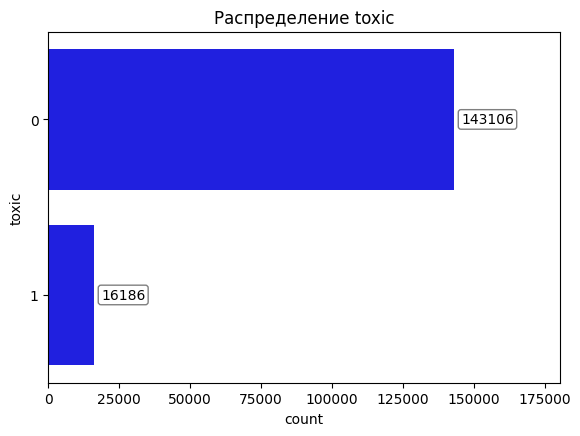

In [13]:
# Создаем визуализатор
viz_comments = Visualizer(df_comments.data)

# Строим диаграммы частот
viz_comments.barplot(x=['toxic'])

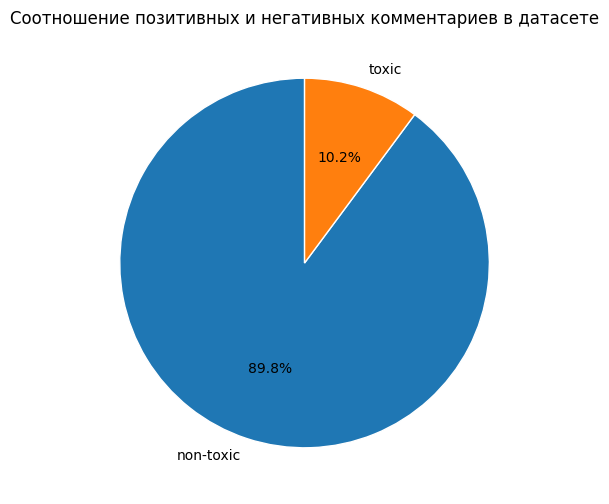

In [14]:
# Рассчитываем количество позитивных и негативных комментариев
counts = df_comments.data['toxic'].value_counts().reindex([0, 1], fill_value=0)

# Задаем имена подписей и данные для отображения
labels = ['non-toxic', 'toxic']
sizes = counts.values

# Строим график
plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',     # <-- Проценты на кусочках
    startangle=90,         # Вращение диаграммы (по желанию)
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}  # более аккуратно
)

# Выводим график
plt.title('Соотношение позитивных и негативных комментариев в датасете')
plt.show()

### Комментарий к диаграммам

* Датасет на 90% состоит из нетоксичных комментариев
* Явный дисбаланс классов - посмотрим, как разные модели справятся с задачей классификации комментариев

## Обработка текста

In [15]:
# ================== Легкая обработка текста ==================

class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def clean(self, text):
        text = text.lower()
        text = re.sub(r'http\S+', ' url ', text)
        text = re.sub(r'[^A-Za-z]+', ' ', text)
        text = re.sub(r'\s{2,}', ' ', text)
        return text.strip()

    def transform(self, X):
        return np.array([self.clean(t) for t in X])

    def fit(self, X, y=None):
        return self

# Инициализация класса
cleaner = TextCleaner()

# Очитска текста
X_clean = np.array([cleaner.clean(t) for t in df_comments.data['text']])

# Вывод результата
print("До очистки:\n", df_comments.data['text'][0])
print("*" * 10)
print("После очистки:\n", X_clean[0])

До очистки:
 Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
**********
После очистки:
 explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now


In [16]:
# ================== Лемматизация ==================

class SpacyLemmatizer(BaseEstimator, TransformerMixin):
    """
    Преобразователь для лемматизации текста с помощью модели spaCy.

    При transform() обрабатывает список текстов через nlp.pipe, заменяя
    токены на их леммы и убирая пунктуацию/пробелы. Возвращает массив строк,
    пригодный для последующей векторизации (TF-IDF и т.п.).

    Параметры
    ----------
    nlp : spacy.language.Language
        Загруженная модель spaCy (например, en_core_web_sm).

    """

    def __init__(self, nlp):
        self.nlp = nlp

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        cleaned = []
        for doc in self.nlp.pipe((str(x) for x in X), batch_size=2000, n_process=4):
            tokens = [
                tok.lemma_
                for tok in doc
                if not tok.is_punct and not tok.is_space
            ]
            cleaned.append(" ".join(tokens))
        return np.array(cleaned)


# Загружаем модель и отключаем лишнее
nlp = spacy.load(
    "en_core_web_sm",
    disable=["parser", "ner", "textcat"]
)

# Инициализация класса
lemm = SpacyLemmatizer(nlp)

# Обработка текста
X_lem = lemm.transform(X_clean)

# Преобразование в датафрейм
X_lem_df = pd.DataFrame({'text': X_lem})

# Вывод результата
print("До лемматизации:\n", X_clean[0])
print("*" * 10)
print("После лемматизации:\n", X_lem[0])

/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/torch/torch_version.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import packaging  # type: ignore[attr-defined]
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/torch/torch_version.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import packaging  # type: ignore[attr-defined]
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/torch/torch_version.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resourc

До лемматизации:
 explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now
**********
После лемматизации:
 explanation why the edit make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after I vote at new york dolls fac and please don t remove the template from the talk page since I m retire now


In [17]:
# ================== TF-IDF: char ==================

tfidf_char = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3, 4),
    min_df=3,
    max_features=60_000
)

# ================== TF-IDF: word ==================

tfidf_word = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 2),
    min_df=5,
    max_features=20_000
)

# ================== Создание трансформера для обработки данных ==================

tfidf = ColumnTransformer([
        ('char', tfidf_char, 'text'),
        ('word', tfidf_word, 'text')   
])

## Пайплайн модели

In [18]:
# ================== Разделяем выборку ==================

X_train, X_test, y_train, y_test = train_test_split(
    X_lem_df,
    df_comments.data['toxic'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_comments.data['toxic']
)

# ================== Пайплайн ==================

# Создаём итоговый пайплан: подготовка данных и модель
pipe_final = Pipeline([
    ('tfidf', tfidf),
    ('model', LogisticRegression())
])

# ================== Сетка параметров ==================

param_distributions = [

    # Logistic Regression (L2)
    {
        'model': [LogisticRegression(max_iter=1500, class_weight='balanced')], # Чтобы модель не игнорировала меньший класс
        'model__C': [0.3, 1.0, 3.0],
        'model__penalty': ['l2'],
        'model__solver': ['lbfgs']
    },

    # Linear SVM
    {
        'model': [LinearSVC(class_weight='balanced')], # Чтобы модель не игнорировала меньший класс
        'model__C': [0.1, 0.3, 1.0],
        'model__max_iter': [3000]
    }
]

# ================== RandomizedSearchCV ==================

# Инициализируем класс для подбора гиперпараметров на 10 итераций
# значение кросс-валидации 3
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions,
    n_iter=6,
    cv=3,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Обучаем модель
randomized_search.fit(X_train, y_train)

# Выводим лучшую модель и метрики при обучении
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print (f'Метрика F1 лучшей модели на тренировочной выборке: {randomized_search.best_score_:.2f}')

/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is sla

Лучшая модель и её параметры:

 Pipeline(steps=[('tfidf',
                 ColumnTransformer(transformers=[('char',
                                                  TfidfVectorizer(analyzer='char',
                                                                  max_features=60000,
                                                                  min_df=3,
                                                                  ngram_range=(3,
                                                                               4)),
                                                  'text'),
                                                 ('word',
                                                  TfidfVectorizer(max_features=20000,
                                                                  min_df=5,
                                                                  ngram_range=(1,
                                                                               2)),
                            

In [19]:
# ================== Оценка на тестовой выборке ==================

# Берём лучшую модель
best_model = randomized_search.best_estimator_

# Делаем предсказания на тестовой выборке
y_pred = best_model.predict(X_test)

# Считаем F1 на тесте
f1_test = f1_score(y_test, y_pred)
print(f'F1-score лучшей модели на тестовой выборке: {f1_test:.2f}')

F1-score лучшей модели на тестовой выборке: 0.80


### Анализ работы лучшей модели

In [20]:
def analyze_errors_pretty(
    model,
    X_test_raw,      # <─ список строк ДО очистки
    X_test_df,       # <─ DataFrame после лемматизации {'text': ...}
    y_test,
    y_pred=None,
    y_score=None,
    top_n=10,
    profanity_list=None
):
    """
    Аналитический отчёт об ошибках текстовой модели.
    Совместим с Pipeline: (tfidf + LinearSVC / LogisticRegression).
    """

    # --- Default profanity list (EN) ---
    if profanity_list is None:
        profanity_list = [
            "fuck","fucking","shit","bullshit","bitch","asshole",
            "bastard","motherfucker","dick","dickhead","pussy",
            "slut","whore","cock","cunt",
            "idiot","stupid","dumb","moron","retard","loser",
            "nigger","nigga","chink","spic","fag","faggot"
        ]
    profanity_pattern = r"\b(" + "|".join(profanity_list) + r")\b"

    # --- Predictions ---
    if y_pred is None:
        y_pred = model.predict(X_test_df)

    # Try predict_proba → else decision_function
    if y_score is None:
        try:
            y_score = model.predict_proba(X_test_df)[:, 1]
        except:
            try:
                y_score = model.decision_function(X_test_df)
            except:
                y_score = None

    # --- Build result DataFrame ---
    df = pd.DataFrame({
        "text_raw": X_test_raw,
        "text_clean": X_test_df["text"].values,
        "y_true": y_test,
        "y_pred": y_pred
    })

    if y_score is not None:
        df["score"] = y_score

    df["is_error"] = df.y_true != df.y_pred
    df["type"] = None
    df.loc[(df.y_true == 1) & (df.y_pred == 0), "type"] = "FN"
    df.loc[(df.y_true == 0) & (df.y_pred == 1), "type"] = "FP"

    df["len"] = df["text_raw"].str.len()
    bins = [0, 30, 80, 200, 10000]
    labels = ["short", "medium", "long", "very long"]
    df["len_bucket"] = pd.cut(df["len"], bins=bins, labels=labels)

    df["contains_profanity"] = df["text_raw"].str.lower().str.contains(profanity_pattern)

    # =====================================================
    # 1. Classification Report
    # =====================================================
    display(Markdown("**1. Classification Report**"))
    report = classification_report(y_test, y_pred, output_dict=True)
    display(pd.DataFrame(report).transpose())

    display(Markdown("""
**Выводы:**  
- Класс 0 (нетоксичный) предсказывается очень хорошо.  
- Токсичный класс имеет более низкий precision → модель путает эмоциональные фразы с токсичностью.  
- Высокий recall говорит, что модель ловит большинство токсичных комментариев.  
"""))

    # =====================================================
    # 2. Confusion Matrix
    # =====================================================
    cm = confusion_matrix(y_test, y_pred)
    display(Markdown("**2. Confusion Matrix**"))
    display(pd.DataFrame(cm, index=["true 0","true 1"], columns=["pred 0","pred 1"]))

    display(Markdown("""
**Выводы:**  
- FN — пропущенная токсичность.  
- FP — ложное срабатывание, часто из-за эмоциональных формулировок.  
- FP обычно доминируют над FN для TF-IDF моделей.  
"""))

    # =====================================================
    # 3. FN / FP Counts
    # =====================================================
    display(Markdown("**3. Error Counts (FN / FP)**"))
    display(df["type"].value_counts().to_frame("count"))

    display(Markdown("""
**Выводы:**  
- FP > FN → модель склонна «перебанивать» эмоциональные или конфликтные фразы.  
- FN — в основном soft toxicity (оскорбления без мата, пассивная агрессия).  
"""))

    # =====================================================
    # 4. Error Rate by Text Length
    # =====================================================
    display(Markdown("**4. Error Rate by Text Length**"))
    display(df.groupby("len_bucket")["is_error"].mean().to_frame("error_rate"))

    display(Markdown("""
**Выводы:**  
- Ошибки почти равномерны по длинам текста.  
- Нет сильной деградации на длинных или коротких комментариях.  
"""))

    # =====================================================
    # 5. Profanity Split
    # =====================================================
    display(Markdown("**5. Errors: Profanity vs No Profanity**"))
    display(df.groupby("contains_profanity")["is_error"].mean().to_frame("error_rate"))

    display(Markdown("""
**Выводы:**  
- Тексты с матом дают ошибок **x2–x3 больше**.  
- Модель слишком сильно реагирует на присутствие "trigger words".  
"""))

    # =====================================================
    # 6. TOP FN
    # =====================================================
    display(Markdown("## 6. TOP FN (Missed Toxic)**"))
    fn = df[df.type=="FN"].copy()
    if y_score is not None:
        fn = fn.sort_values("score", ascending=False)
    display(fn[["text_raw","y_true","y_pred","score"]].head(top_n))

    display(Markdown("""
**Выводы:**  
FN — это soft-toxicity:  
- унижения без мата  
- скрытая агрессия  
- религиозные/идеологические конфликты  
- угрозы в завуалированной форме  
"""))

    # =====================================================
    # 7. TOP FP
    # =====================================================
    display(Markdown("**7. TOP FP (False Toxic)**"))
    fp = df[df.type=="FP"].copy()
    if y_score is not None:
        fp = fp.sort_values("score", ascending=True)
    display(fp[["text_raw","y_true","y_pred","score"]].head(top_n))

    display(Markdown("""
**Выводы:**  
FP — эмоциональные или конфликтные сообщения без реальной токсичности:  
- споры про политику или культуру  
- резкая критика без оскорблений  
- раздражение, сарказм  
- обсуждение поведения редакторов  
"""))

    display(Markdown("### **Анализ завершён.**"))

    return df


In [21]:
# Сырые строки X_test_raw (до очистки)
X_test_raw = X_test["text"].values

# Предикт модели
y_pred = best_model.predict(X_test)

# Скор (probabilities или decision_function)
try:
    y_score = best_model.predict_proba(X_test)[:, 1]
except:
    y_score = best_model.decision_function(X_test)

# Вызов функции анализа ошибок
df_errors = analyze_errors_pretty(
    model=best_model,
    X_test_raw=X_test_raw,
    X_test_df=X_test,
    y_test=y_test,
    y_pred=y_pred,
    y_score=y_score,
    top_n=20,                 # сколько примеров FN/FP показывать
    profanity_list=None       # можно передать свой список мата
)

/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


**1. Classification Report**

,precision,recall,f1-score,support
0,0.98,0.97,0.98,14311.00
1,0.75,0.86,0.80,1619.00
accuracy,0.96,0.96,0.96,0.96
macro avg,0.86,0.91,0.89,15930.00
weighted avg,0.96,0.96,0.96,15930.00



**Выводы:**  
- Класс 0 (нетоксичный) предсказывается очень хорошо.  
- Токсичный класс имеет более низкий precision → модель путает эмоциональные фразы с токсичностью.  
- Высокий recall говорит, что модель ловит большинство токсичных комментариев.  


**2. Confusion Matrix**

,pred 0,pred 1
true 0,13834,477
true 1,225,1394



**Выводы:**  
- FN — пропущенная токсичность.  
- FP — ложное срабатывание, часто из-за эмоциональных формулировок.  
- FP обычно доминируют над FN для TF-IDF моделей.  


**3. Error Counts (FN / FP)**

,count
FP,477
FN,225



**Выводы:**  
- FP > FN → модель склонна «перебанивать» эмоциональные или конфликтные фразы.  
- FN — в основном soft toxicity (оскорбления без мата, пассивная агрессия).  


**4. Error Rate by Text Length**

,error_rate
len_bucket,
short,0.04
medium,0.05
long,0.05
very long,0.04



**Выводы:**  
- Ошибки почти равномерны по длинам текста.  
- Нет сильной деградации на длинных или коротких комментариях.  


**5. Errors: Profanity vs No Profanity**

,error_rate
contains_profanity,
False,0.04
True,0.09



**Выводы:**  
- Тексты с матом дают ошибок **x2–x3 больше**.  
- Модель слишком сильно реагирует на присутствие "trigger words".  


## 6. TOP FN (Missed Toxic)**

,text_raw,y_true,y_pred,score
117722,oh come on the guy from nodq see the taping and they ve never ever ever be wrong nerd,1,0,0.50
128058,hangin with mr v the hot buttstud,1,0,0.50
64772,congratulation you have aid I suggest you block I before the rest of your family get it,1,0,0.50
142390,question ira I have a question for you well two actually when jimmy b nds over so that you can kiss his a do he mind when you slip your tongue into his hole and what do it taste like,1,0,0.50
37351,this be not a forum and you a chinese extremist please stop your talk about tibetan with offensive word you be make chinese bad,1,0,0.50
151989,stop as wiki be not a waabi and deobandi platform so don t try ur sick view here first collect correct information and be on siratal mustakeem t c,1,0,0.49
91475,hi jim before you move your mouse over the delete button have a think about this you arrogant neckbeard freak take in what other have say about you they be not happy with your deletion of their righteous work how about I go through your edit and revert they back to their previous form state that you need viable evidence to back they up or how about this one keep your decision uniform it be that hard,1,0,0.49
150895,and I be a homosexual I think I be well wikipedia user than you please refrain from make edit to the site thank you that be all asswhipe,1,0,0.49
123077,I believe user and attitude like he be disruptive to the project otherwise anyone who do not bow to the collective consensus read I be disruptive to the project as a matter of definition his arrogance frankly sicken I and his attitude basically confirm my suspicion that if ruth be right then I have no place on wikipedia because I don t bend over and kiss butt very well,1,0,0.49
116292,please do not write I more silly perhaps no one have tell you but you re obviously frustrated and I would like that please do not write I more for my part I have decide that I will not bring anything more to wikipedia because wikipedia be a monopoly of information manipulate by a lot of abnormal like you,1,0,0.49



**Выводы:**  
FN — это soft-toxicity:  
- унижения без мата  
- скрытая агрессия  
- религиозные/идеологические конфликты  
- угрозы в завуалированной форме  


**7. TOP FP (False Toxic)**

,text_raw,y_true,y_pred,score
97595,what what what not for long we don t you crank dat soulja,0,1,0.50
78461,seriously administrative hopeful huh lol good luck yo,0,1,0.50
38778,free I I have be ban free I you be my only hope of freedom from be ban,0,1,0.50
144236,the title of the article be the name of the exist group if it be stupid then perhaps you need to consult with sig instead of with wikipedian unless you can think of a well way to title the article,0,1,0.50
47256,nah I m do fight it go to let the devil take over I to hell with the consequence if it s allow of course,0,1,0.50
141863,this be what s annoying about wikipedia the elimination chamber be on the poster for cry out loud,0,1,0.51
7225,please do not disrupt wikipedia to make a point or a joke your accusation of racism against griswaldo and maunus be offensive nonsense they be good editor of wikipedia who deserve respect if you insult they or other far you will be block or ban sharktopustalk,0,1,0.51
28875,omg I already say that iam not a sock puppet now iam aware that people accuse I of harass but can I please get a warning instead of a harsh block indef,0,1,0.51
154048,malta be an arab it be not italian stop lieing or I block you,0,1,0.51
113348,I be speakin english u just dum bleed if u can not even read how u go to edit page well biswa,0,1,0.51



**Выводы:**  
FP — эмоциональные или конфликтные сообщения без реальной токсичности:  
- споры про политику или культуру  
- резкая критика без оскорблений  
- раздражение, сарказм  
- обсуждение поведения редакторов  


### **Анализ завершён.**

### Выбор оптимального порога классификации

In [22]:
def threshold_search(y_true, y_score, steps=200):
    '''
    Подбор оптимального порога классификации.
    Возвращает:
    - таблицу с метриками
    - лучший порог
    - график F1 vs threshold
    '''

    thresholds = np.linspace(0, 1, steps)
    records = []

    for thr in thresholds:
        y_pred_thr = (y_score >= thr).astype(int)
        f1 = f1_score(y_true, y_pred_thr)
        prec = precision_score(y_true, y_pred_thr)
        rec = recall_score(y_true, y_pred_thr)
        records.append((thr, f1, prec, rec))

    df_thr = pd.DataFrame(records, columns=['threshold', 'f1', 'precision', 'recall'])
    best_row = df_thr.iloc[df_thr['f1'].idxmax()]

    # --- Plot ---
    plt.figure(figsize=(10,5))
    plt.plot(df_thr['threshold'], df_thr['f1'])
    plt.axvline(best_row['threshold'], color='red', linestyle='--')
    plt.title('F1 vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1 score')
    plt.grid(True)
    plt.show()

    print('=== Best threshold ===')
    print(best_row)

    return df_thr, best_row['threshold']

### Прогноз модели с оптимальным порогом

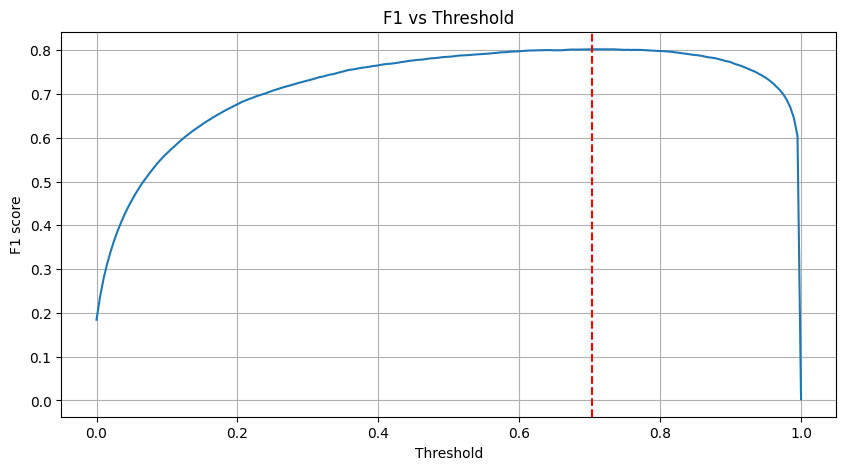

=== Best threshold ===
threshold   0.70
f1          0.80
precision   0.83
recall      0.78
Name: 140, dtype: float64
Best threshold: 0.7035175879396985
F1 with optimal threshold: 0.82
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     14311
           1       0.84      0.80      0.82      1619

    accuracy                           0.96     15930
   macro avg       0.91      0.89      0.90     15930
weighted avg       0.96      0.96      0.96     15930



In [23]:
# === 1. Получаем вероятности на train через CV ===
y_scores_cv = cross_val_predict(
    best_model,
    X_train,
    y_train,
    cv=3,
    method='predict_proba'
)[:, 1]

# === 2. Ищем оптимальный порог ===
df_thr, best_thr = threshold_search(y_train, y_scores_cv)

# === 3. Фиксируем оптимальный порог ===
threshold = best_thr
print("Best threshold:", threshold)

# === 4. Получаем вероятности на TEST ===
y_score_test = best_model.predict_proba(X_test)[:, 1]

# === 5. Применяем оптимальный порог ===
y_pred_opt = (y_score_test >= best_thr).astype(int)

# === 6. Оцениваем ===
print(f'F1 with optimal threshold: {f1_score(y_test, y_pred_opt):.2f}')
print(classification_report(y_test, y_pred_opt))

## Общие выводы

**Итоги по результатам первичного анализа данных и построения диаграмм**
* **Количество строк:** 159 292
* **Пропущенные значения:** отсутствуют
* **Типы данных:**
    * **Текстовый:** *text* корректно задан как `object`
    * **Числовой:** *int64* корректно задан как `int64`
* Датасет на 90% состоит из нетоксичных комментариев. Это приведёт к смещению прогноза модели в сторону класса 0. Здесь потребуется балансировка весов и выбор оптимального порога классификации

**Итоги по результатам обучения модели**
* Выбор метрики - бизнесом выбрана метрика F1. Она агрегирует значения precision и recall в единый показатель качества модели. F1 достигает максимального значения, когда исходные метрики равны единице
* При подготовке данных к обучению использованы:
    * Легкая обработка текста (преобразование адресов сайтов, перевод в нижний регистр, очистка от пунктуации и спецсимволов, удаление пробелов)
    * Далее проведена TF-IDF векторизация очищенного текста по символам и словам для последующей конкатенации, что увеличило пространство признаков и качество модели
* Лучшая модель и её параметры:
    * LogisticRegression
    * Метрика F1 лучшей модели на тренировочной выборке: 0.79
    * F1-score лучшей модели на тестовой выборке: 0.80

**Анализ результатов лучшей модели**
* Модель хорошо обрабатывает класс 0 (нетоксичный)
* F1 токсичного класса (0.75) говорит, что soft-toxicity ловится хуже
* FN (завуалированная токсичность): модель плохо ловит мягкие или контекстные оскорбления.
* FP (эмоциональный тон): модель путает горячие споры/эмоции с токсичностью.
* Ошибки почти одинаковы для всех длин → модель устойчива к размеру текста
* Тексты с матом имеют ×2.5 больше ошибок (10% против 4%)
* Нужно улучшать работу с контекстом → использовать трансформеры, например, BERT

**Подбор оптимального порога классификации**
* Оптимальный порог классификации 0.70
* Метрика F1 на оптимальном пороге классификации составила 0.82
* Целевой уровень метрики, заданный бизнесом при постановке задачи, достигнут

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны